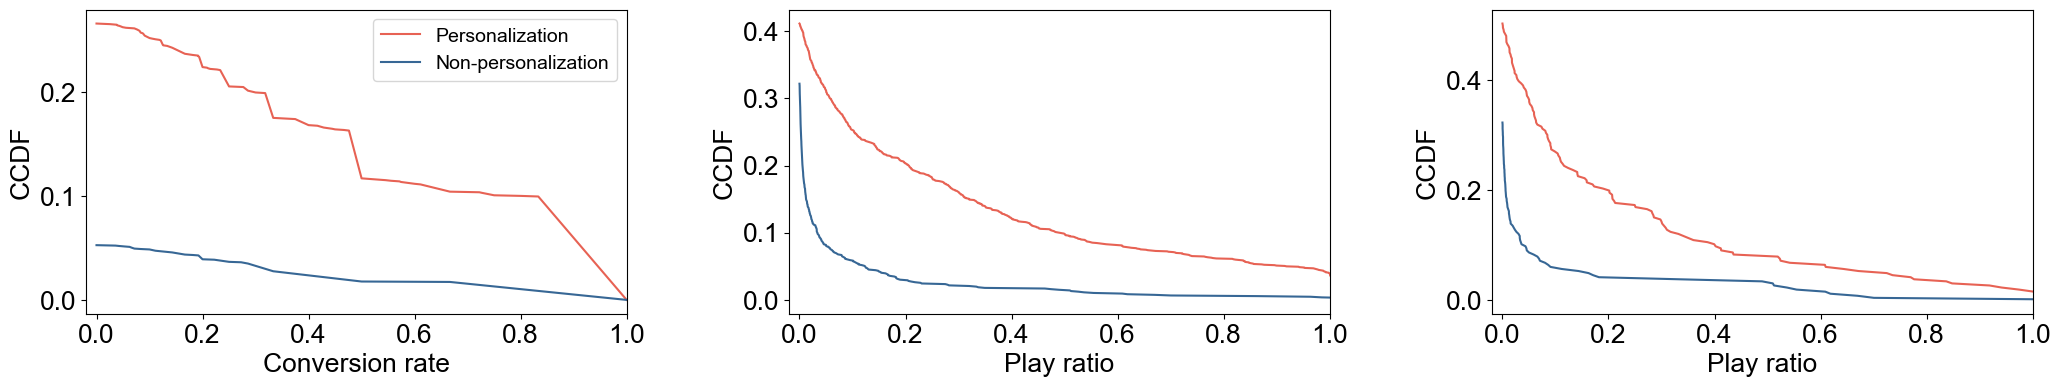

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
import matplotlib.gridspec as gridspec

def get_ccdf(value_df, target):
    value_counts = value_df[target].value_counts()
    value_counts_df = pd.DataFrame({target: value_counts.index, 'count': value_counts.values})
    value_counts_df = value_counts_df.sort_values(by=target, ascending=True)
    total_count = value_counts_df['count'].sum()
    value_counts_df['count'] = value_counts_df['count'] / total_count
    ccdf = 1 - value_counts_df['count'].cumsum()
    return value_counts_df[target], ccdf[:]

match_group = 'A'
photo_type = 'misinformation'
page = 'find'

# read data
personal_interaction = pd.read_csv(f'../data/personal_{page}_misinformation_play_ratio_group{match_group}.csv')
no_personal_interaction = pd.read_csv(f'../data/no_personal_{page}_misinformation_play_ratio_group{match_group}.csv')
personal_interaction = personal_interaction[personal_interaction['show_cnt']!=0].copy()
no_personal_interaction = no_personal_interaction[no_personal_interaction['show_cnt']!=0].copy()
    
# find common videos
personal_photo_ids = set(personal_interaction['photo_id'])
no_personal_photo_ids = set(no_personal_interaction['photo_id'])
common_photo_ids = personal_photo_ids.intersection(no_personal_photo_ids)
common_photo_id_df = pd.DataFrame(data=common_photo_ids,columns=['photo_id'])

# statistics
personal_conversionrate_matrix = personal_interaction.groupby('device_id').agg({
    'valid_play_cnt': 'sum',
    'show_cnt': 'sum'
})
no_personal_conversionrate_matrix = no_personal_interaction.groupby('device_id').agg({
    'valid_play_cnt': 'sum',
    'show_cnt': 'sum'
})

personal_conversionrate_matrix['conversion_rate'] = personal_conversionrate_matrix['valid_play_cnt'] / personal_conversionrate_matrix['show_cnt']
no_personal_conversionrate_matrix['conversion_rate'] = no_personal_conversionrate_matrix['valid_play_cnt'] / no_personal_conversionrate_matrix['show_cnt']
    
personal_interaction['play_ratio'] = personal_interaction['play_duration'] / personal_interaction['photo_duration']
personal_photo_play_ratio = personal_interaction.groupby('photo_id')['play_ratio'].mean().reset_index()
no_personal_interaction['play_ratio'] = no_personal_interaction['play_duration'] / no_personal_interaction['photo_duration']
no_personal_photo_play_ratio = no_personal_interaction.groupby('photo_id')['play_ratio'].mean().reset_index()

# plot
fig = plt.figure(figsize=(21, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])  
axes = [plt.subplot(gs[i]) for i in range(3)]  

############################################## Conversion rate ################################################
x,y = get_ccdf(personal_conversionrate_matrix,'conversion_rate')
axes[0].plot(x,y,color = '#e76254', linestyle = '-',label = 'Personalization')
x,y = get_ccdf(no_personal_conversionrate_matrix,'conversion_rate')
axes[0].plot(x,y,color = '#376795', linestyle = '-',label = 'Non-personalization')

############################################## all videos ################################################
x,y = get_ccdf(personal_photo_play_ratio,'play_ratio')
axes[1].plot(x,y,color = '#e76254', linestyle = '-',label = 'Personalization')
x,y = get_ccdf(no_personal_photo_play_ratio,'play_ratio')
axes[1].plot(x,y,color = '#376795', linestyle = '-',label = 'Non-personalization')

############################################## Common videos ################################################
personal_interaction = pd.merge(personal_interaction, common_photo_id_df, how='inner', on='photo_id')
no_personal_interaction = pd.merge(no_personal_interaction, common_photo_id_df, how='inner', on='photo_id')

personal_interaction['play_ratio'] = personal_interaction['play_duration'] / personal_interaction['photo_duration']
personal_photo_play_ratio = personal_interaction.groupby('photo_id')['play_ratio'].mean().reset_index()
no_personal_interaction['play_ratio'] = no_personal_interaction['play_duration'] / no_personal_interaction['photo_duration']
no_personal_photo_play_ratio = no_personal_interaction.groupby('photo_id')['play_ratio'].mean().reset_index()
    
x,y = get_ccdf(personal_photo_play_ratio,'play_ratio')
axes[2].plot(x,y,color = '#e76254', linestyle = '-',label = 'Personalization')
x,y = get_ccdf(no_personal_photo_play_ratio,'play_ratio')
axes[2].plot(x,y,color = '#376795', linestyle = '-',label = 'Non-personalization')

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
font_size = 19
tick_size = 19
axes[0].legend(fontsize = font_size-5, loc='upper right')
axes[0].set_ylabel('CCDF', fontsize = font_size)
axes[0].set_xlabel('Conversion rate', fontsize = font_size)  
axes[0].set_xlim((-0.02,1))
axes[0].tick_params(labelsize=tick_size) 
for i in range(1,3):
    axes[i].set_ylabel('CCDF', fontsize = font_size)
    axes[i].set_xlabel('Play ratio', fontsize = font_size)  
    axes[i].set_xlim((-0.02,1))
    axes[i].tick_params(labelsize=tick_size) 

plt.subplots_adjust(left=0.05, bottom=0.16, right=0.977, top=0.92, wspace=0.3, hspace=0.5)
plt.show()